# Compute MHD fieldlines for 3D printing

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import astro3d
from astro3d import image_stack

Read **STEFAN HEIGLS** data:

In [2]:
data_path = Path(astro3d.get_data('diskdata'))
dataset = {}

for fname in data_path.glob('*.npz'):
    print(f'reading in {fname.stem}')

    with np.load(fname) as f:
        dataset[fname.stem] = f['arr_0'][()]
        
rho = dataset['rho']
bfield = np.stack((dataset['magx'], dataset['magy'], dataset['magz']), axis=-1)

reading in rho
reading in magx
reading in magy
reading in magz


Create a grid of original positions

In [3]:
x = np.linspace(0, 1, rho.shape[0])
y = np.linspace(0, 1, rho.shape[1])
z = np.linspace(0, 1, rho.shape[2])

## Test streamline in 2D

We set the z-component to zero and test
1) the computation of the  streamline and
2) how the streamline is masked in the image

In [4]:
# use the magentic field but with B_z = 0
vel = bfield.copy()
vel[:,:,:,-1] = 0.0

# compute stream line
path = image_stack.streamline(x, y, z, vel, [0.1,0.9,0], n_steps=20)

# compute the mask with a radius of 2 pixels
mask = astro3d.fmodule.mark_streamline(x, y, z, 2.0 * np.diff(x)[0], path)

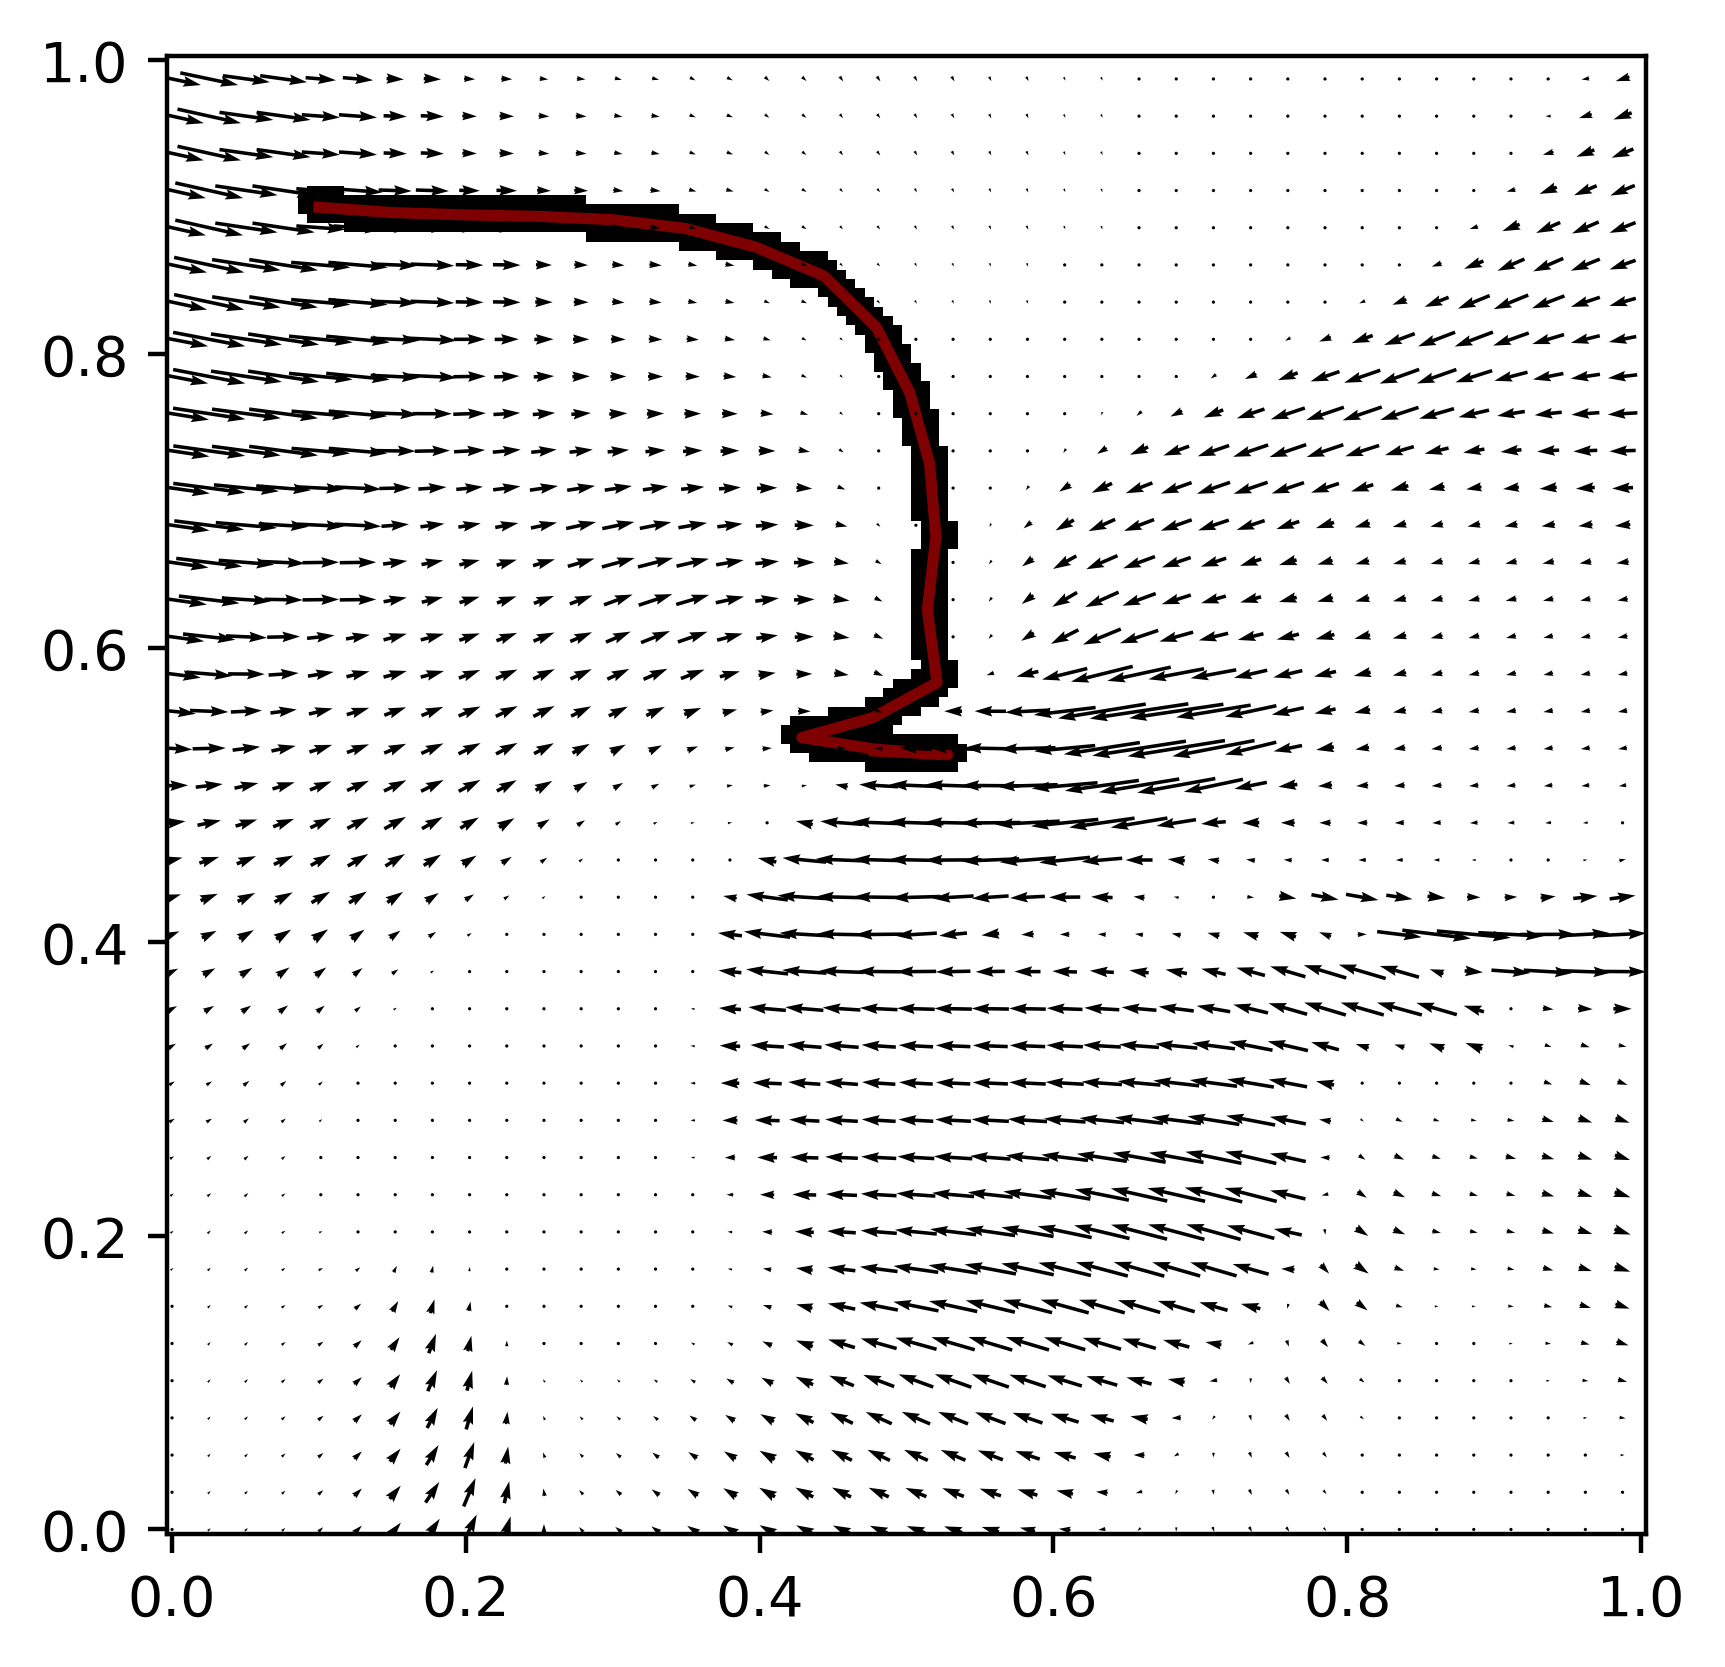

In [5]:
f, ax = plt.subplots(dpi=200)
ax.set_aspect(1)

# plot the image
plt.pcolormesh(x, y, mask.T, cmap='gray_r')

# plot the stream line
ax.plot(*path[:,:2].T, 'r-', lw=2, alpha=0.5);

# plot the vector field
s = 4
ax.quiver(x[::s], y[::s], vel[::s,::s,0,0].T, vel[::s,::s,0,1].T, angles='xy', zorder=100, pivot='mid');

## 3D Streamlines

Here we compute a grid of stream lines and vizualize them. We also store the list of streamlines in a file for 3D printing.

In [6]:
%matplotlib widget

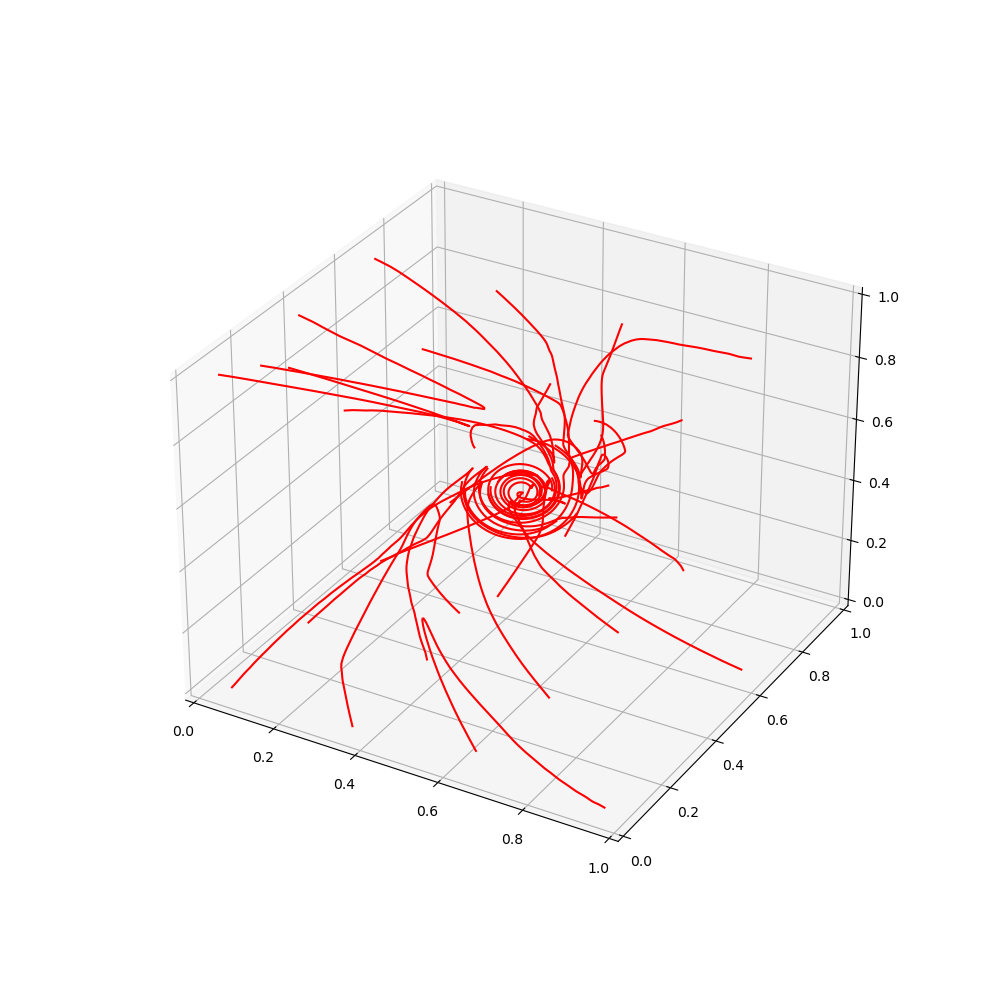

In [7]:
xp = np.linspace(0.05, 0.95, 4)
yp = np.linspace(0.05, 0.95, 4)
pathes = []

f = plt.figure(figsize=(10,10))
ax = f.add_subplot(projection='3d')
for _x in xp:
    for _y in yp:
        for _z in [0,1]:
            path0 = image_stack.streamline(x, y, z, +bfield, [_x, _y, _z], n_steps=200)
            path = image_stack.streamline(x, y, z, -bfield, [_x, _y, _z], n_steps=200)
            path = np.vstack((path[::-1,:], path0))
            
            # get rid of all points that are identical with the first or last point
            mask = np.all(path != path[-1], 1) & np.all(path != path[0], 1)
            path_mod = np.vstack((path[0,:], path[mask],  path[-1,:]))
            
            # get rid of short stream lines
            if path_mod.shape[0] > 100:
                ax.plot(*path.T, c='r')
                pathes += [path_mod]

ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_zlim(0,1)

# store it in the output folder
fname = Path(astro3d.get_output()) / 'streamlines.npz'
np.savez_compressed(fname, pathes=np.array(pathes, dtype=object))